# Simple Generative Adversarial Network (GANs) with Keras

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

https://github.com/eriklindernoren/Keras-GAN 

In [1]:
import sys
import numpy as np
from IPython.core.debugger import Tracer
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

%matplotlib inline
import matplotlib.pyplot as plt


e:\programdata\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class GAN(object):
    def __init__(self, width = 28, height= 28, channels = 1):
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (self.WIDTH, self.HEIGHT, self.CHANNELS)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        self.noise_gen = np.random.normal(0,1,(100,))
        
        self.G = self.generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        
        self.stacked_G_D = self.stacked_G_D()
        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        
    def generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        shapeX = int((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)
        model.add(Dense(shapeX))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        return model


    def stacked_G_D(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model


    def train(self, X_train, epochs=20000, batch = 32, save_interval = 200):
        for cnt in range(epochs):
            ## train discriminator
            random_index =  np.random.randint(0, len(X_train) - batch/2)
            legit_images = X_train[random_index : int(random_index + batch/2)].reshape(int(batch/2), self.WIDTH, self.HEIGHT, self.CHANNELS)
            
            gen_noise = np.random.normal(0, 1, (int(batch/2),100))
            syntetic_images = self.G.predict(gen_noise)
            
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            # train generator
            noise = np.random.normal(0, 1, (batch,100))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)

            if cnt % save_interval == 0 : 
                print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))
                self.plot_images(save2file=False, step=cnt)


    def plot_images(self, save2file=False,  samples=16, step=0):
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples,100))
        images = self.G.predict(noise)

        plt.figure(figsize=(10,10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [ self.HEIGHT, self.WIDTH ])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()        


In [3]:
        
(X_train, _), (_, _) = mnist.load_data()
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


e:\programdata\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.518560], [ Generator :: loss: 0.665777]


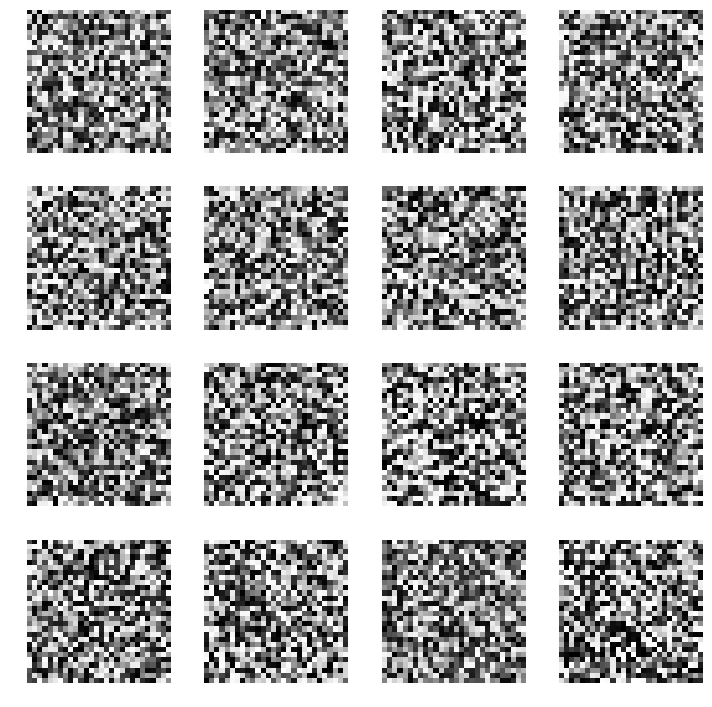

epoch: 1000, [Discriminator :: d_loss: 0.203403], [ Generator :: loss: 2.635849]


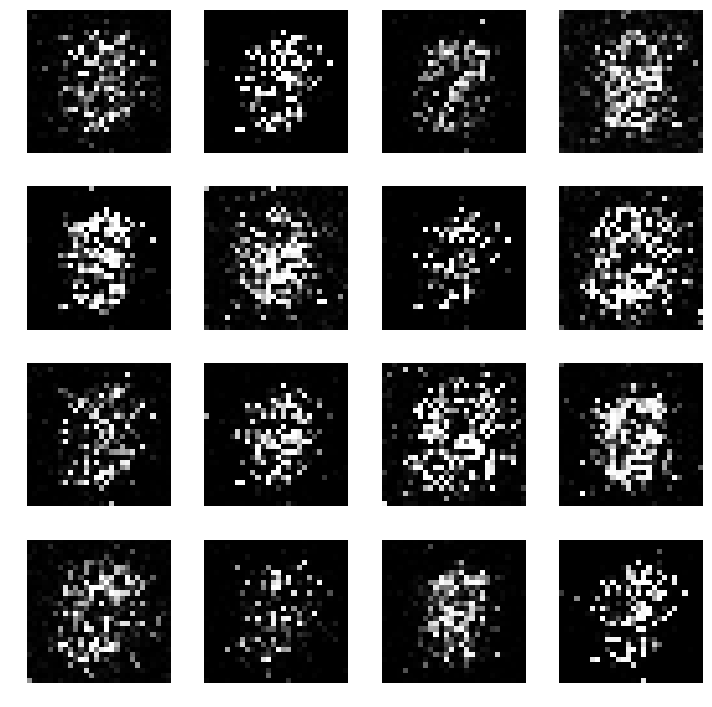

epoch: 2000, [Discriminator :: d_loss: 0.237257], [ Generator :: loss: 4.059638]


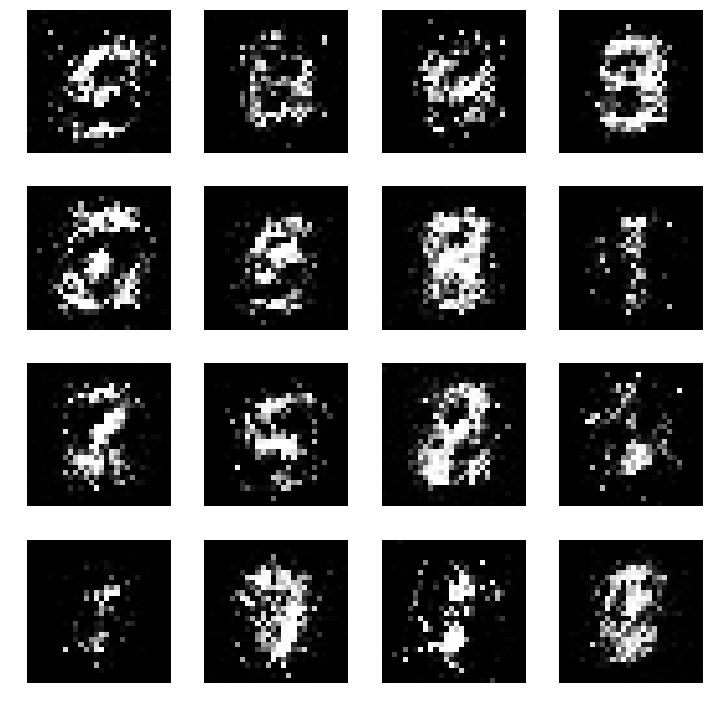

epoch: 3000, [Discriminator :: d_loss: 0.489221], [ Generator :: loss: 2.368094]


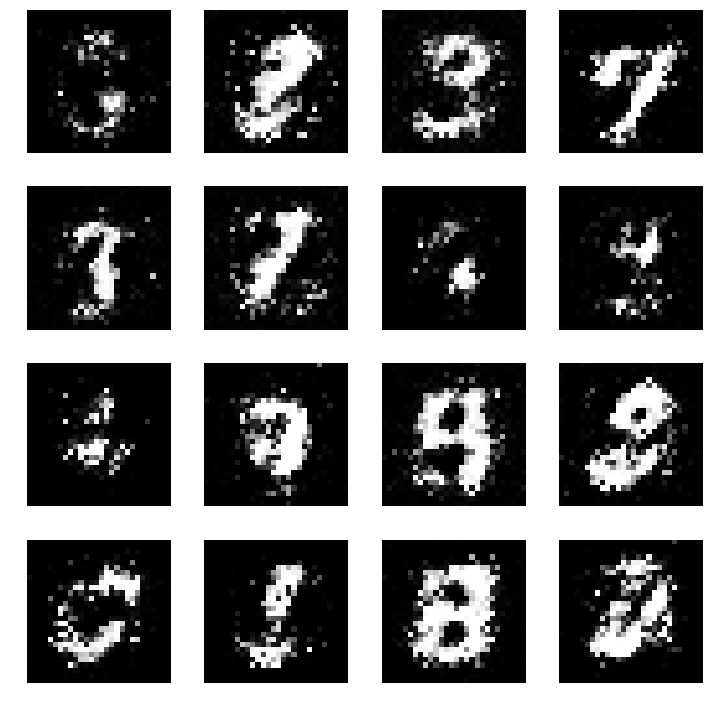

epoch: 4000, [Discriminator :: d_loss: 0.541325], [ Generator :: loss: 1.428771]


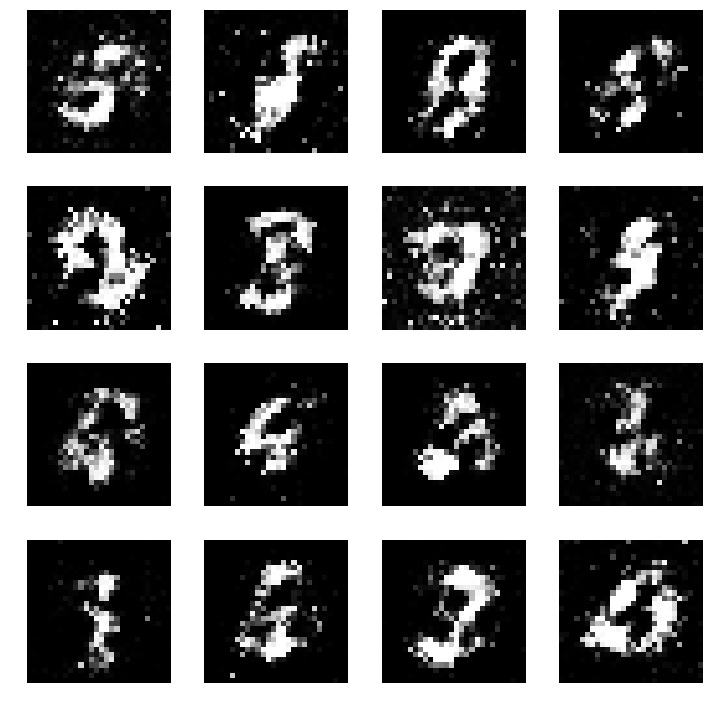

epoch: 5000, [Discriminator :: d_loss: 0.568346], [ Generator :: loss: 1.934682]


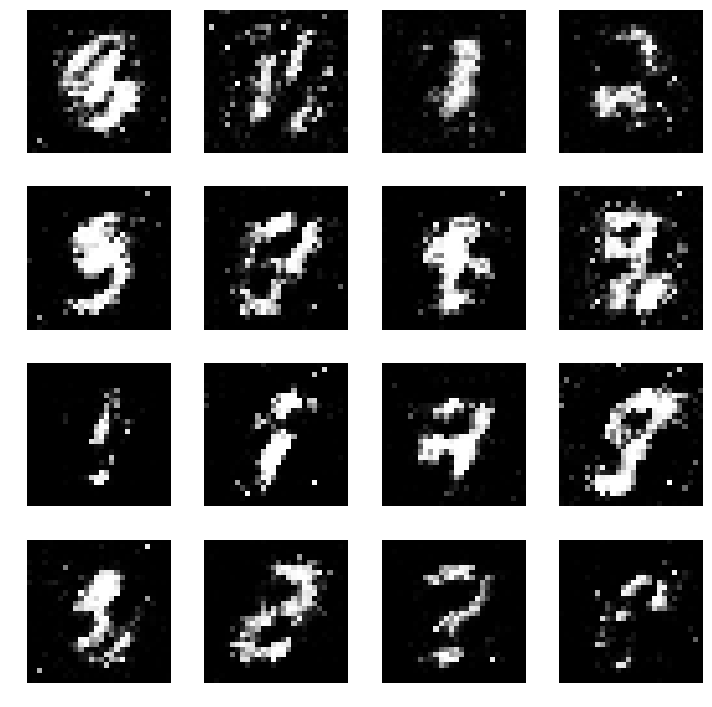

epoch: 6000, [Discriminator :: d_loss: 0.518503], [ Generator :: loss: 1.460326]


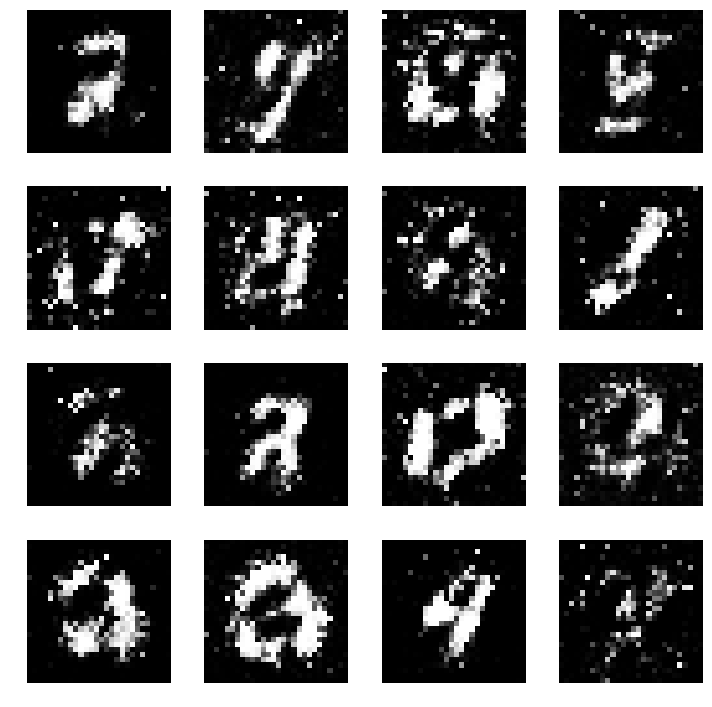

epoch: 7000, [Discriminator :: d_loss: 0.407771], [ Generator :: loss: 1.504315]


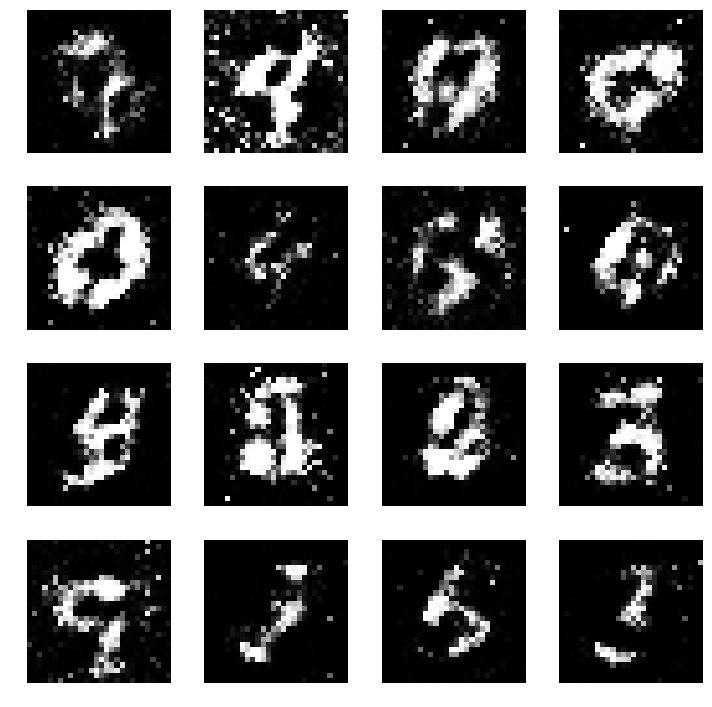

epoch: 8000, [Discriminator :: d_loss: 0.761251], [ Generator :: loss: 1.062627]


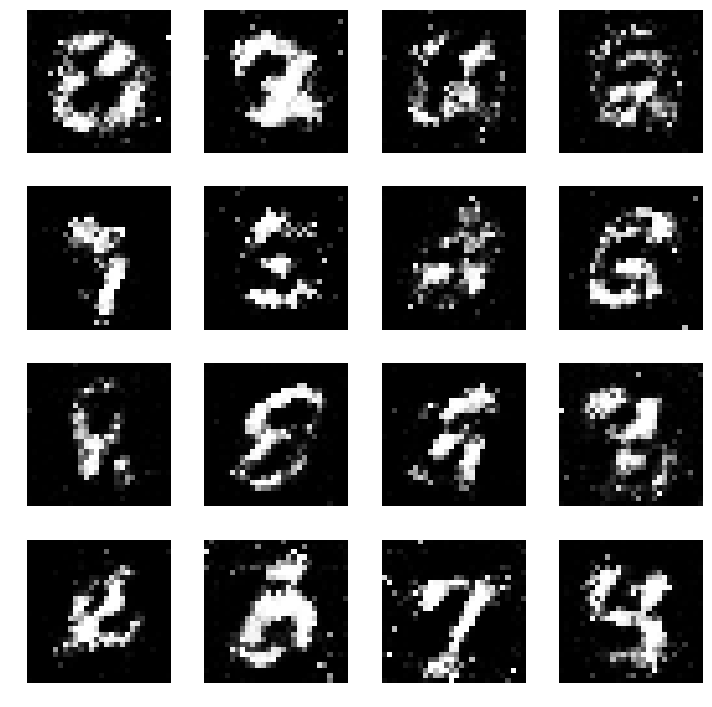

epoch: 9000, [Discriminator :: d_loss: 0.535718], [ Generator :: loss: 0.811735]


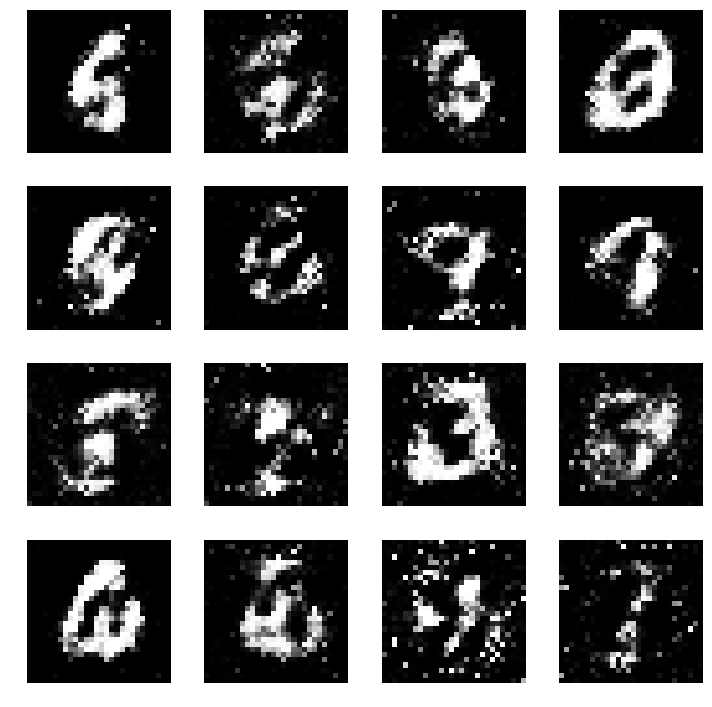

epoch: 10000, [Discriminator :: d_loss: 0.655947], [ Generator :: loss: 1.315603]


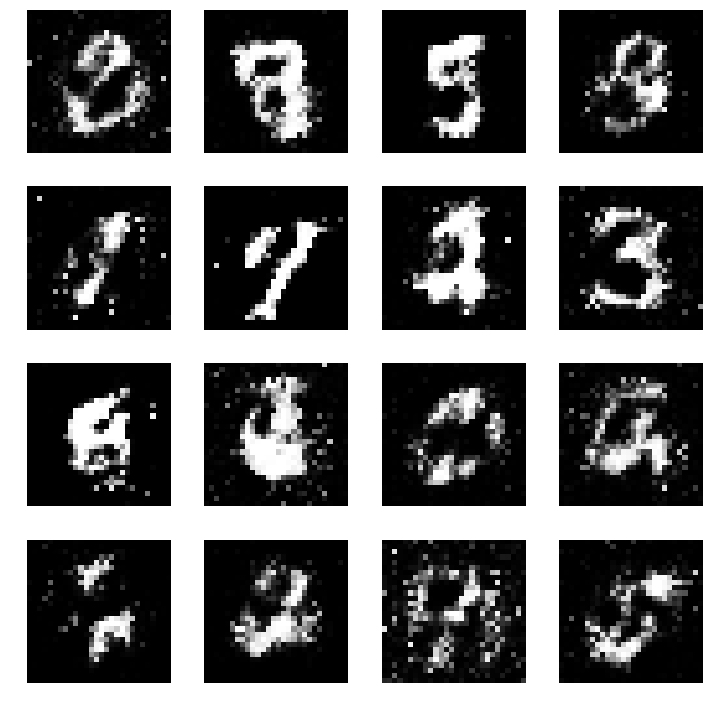

epoch: 11000, [Discriminator :: d_loss: 0.540459], [ Generator :: loss: 1.401153]


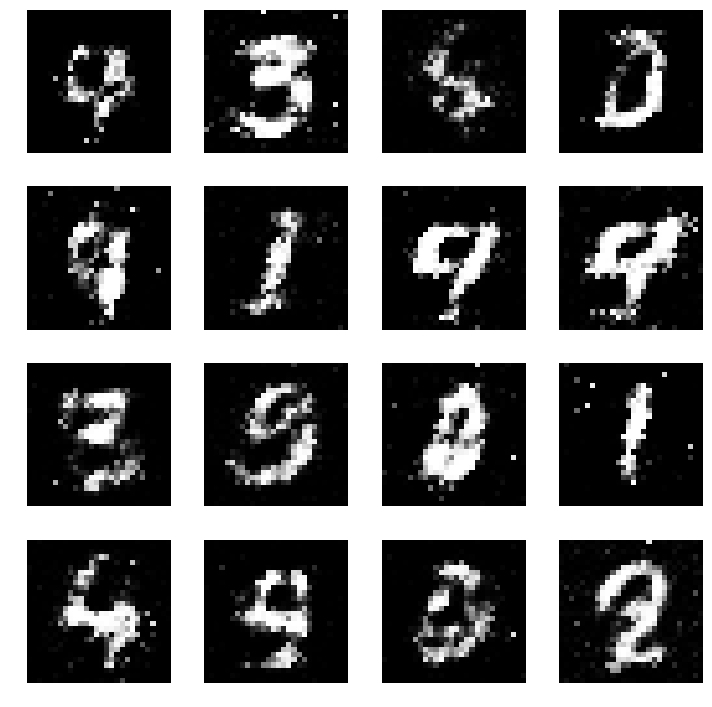

epoch: 12000, [Discriminator :: d_loss: 0.670396], [ Generator :: loss: 0.895745]


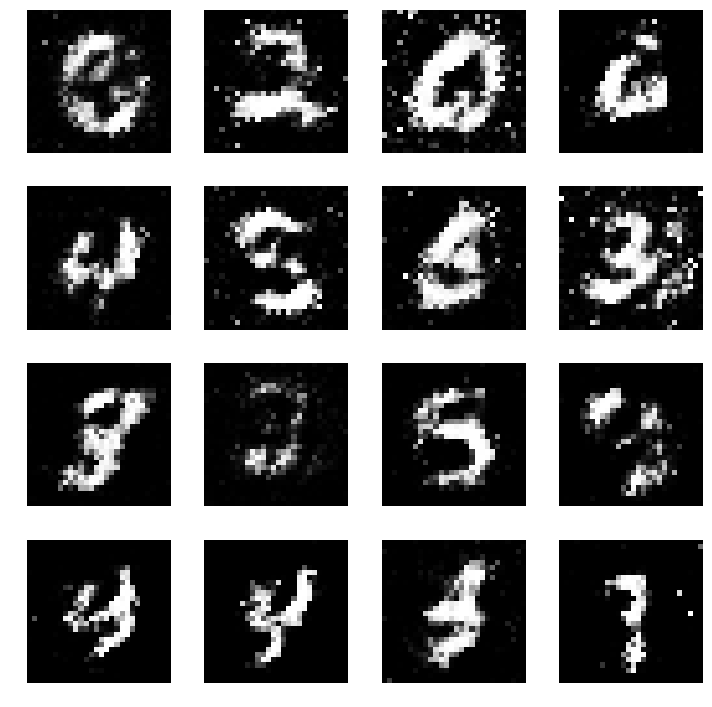

epoch: 13000, [Discriminator :: d_loss: 0.596468], [ Generator :: loss: 1.456245]


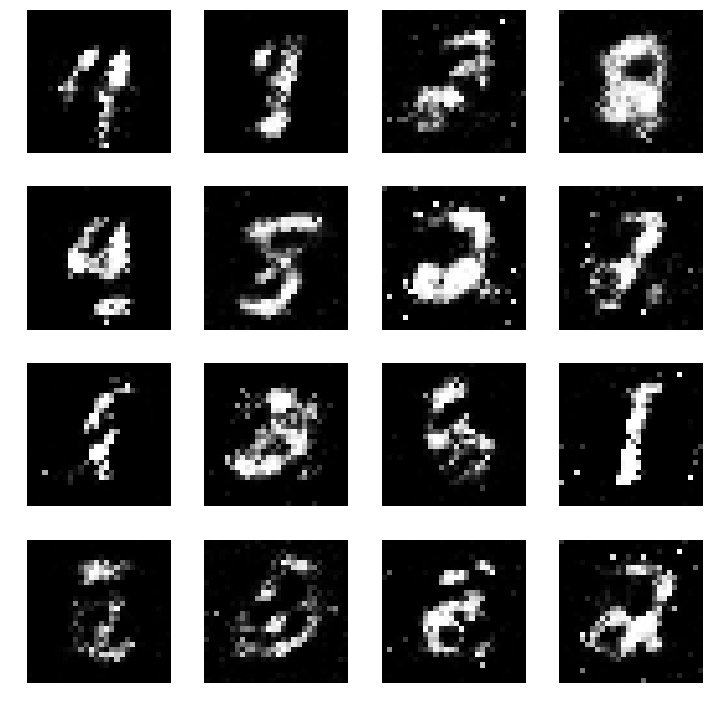

epoch: 14000, [Discriminator :: d_loss: 0.643831], [ Generator :: loss: 1.182098]


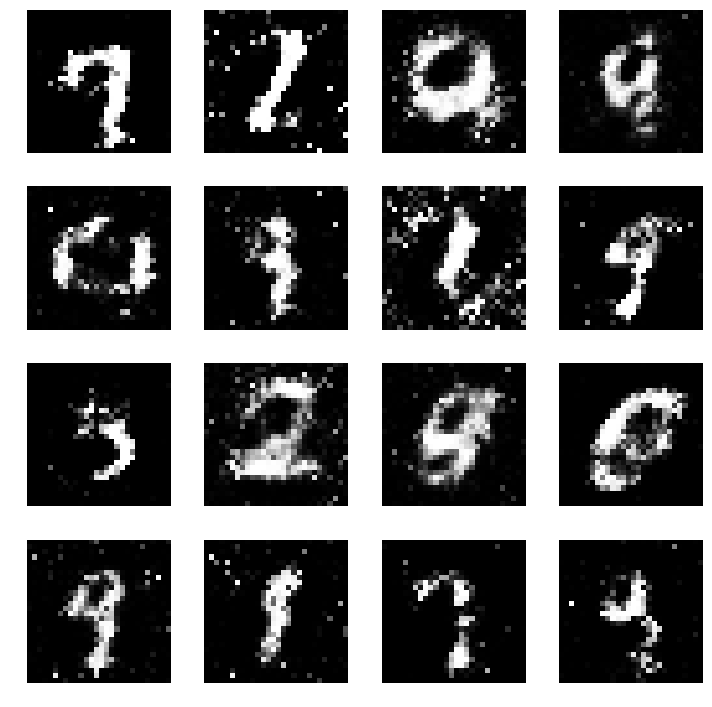

epoch: 15000, [Discriminator :: d_loss: 0.515621], [ Generator :: loss: 1.345066]


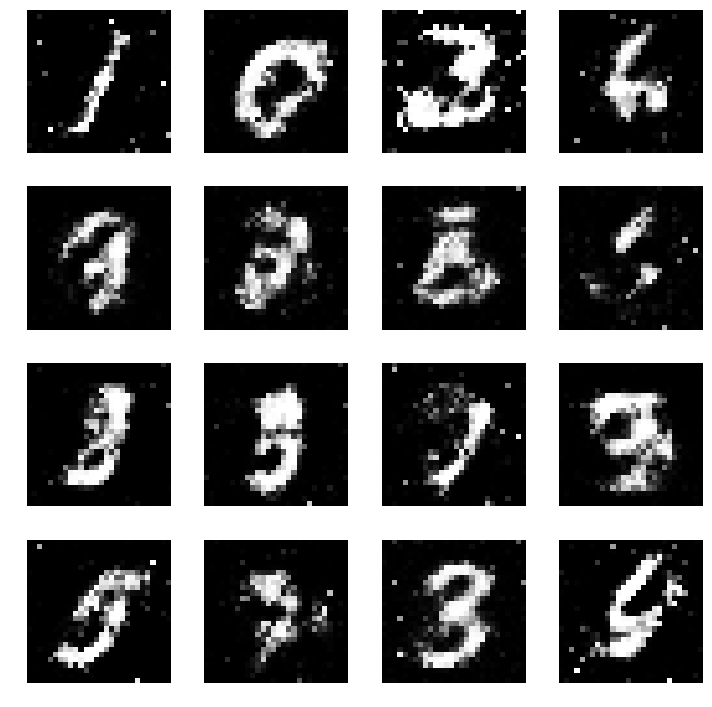

epoch: 16000, [Discriminator :: d_loss: 0.549113], [ Generator :: loss: 0.957540]


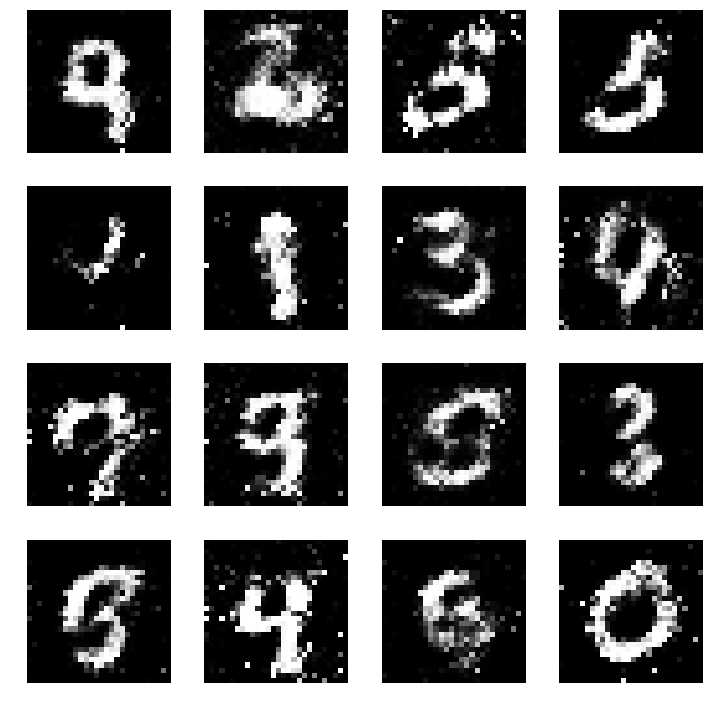

epoch: 17000, [Discriminator :: d_loss: 0.565703], [ Generator :: loss: 1.236933]


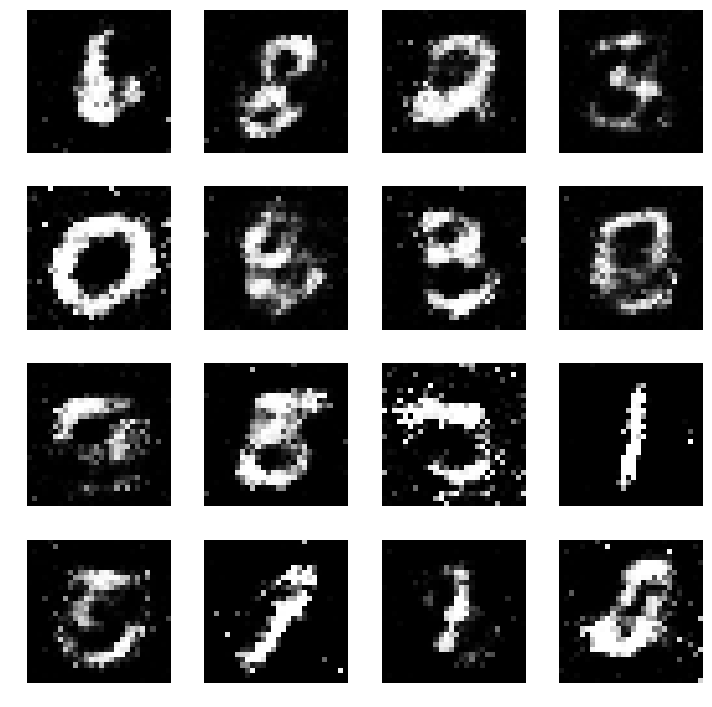

epoch: 18000, [Discriminator :: d_loss: 0.536739], [ Generator :: loss: 1.147491]


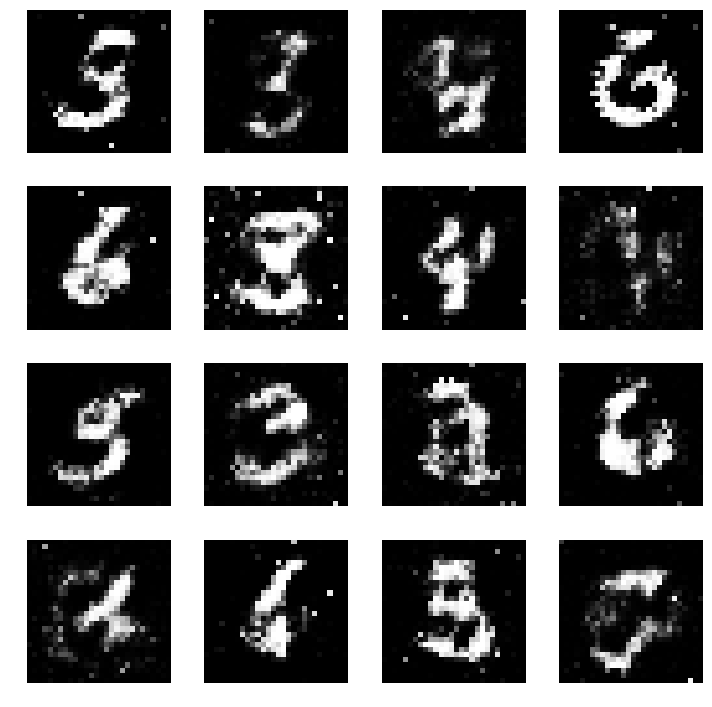

epoch: 19000, [Discriminator :: d_loss: 0.513130], [ Generator :: loss: 1.863898]


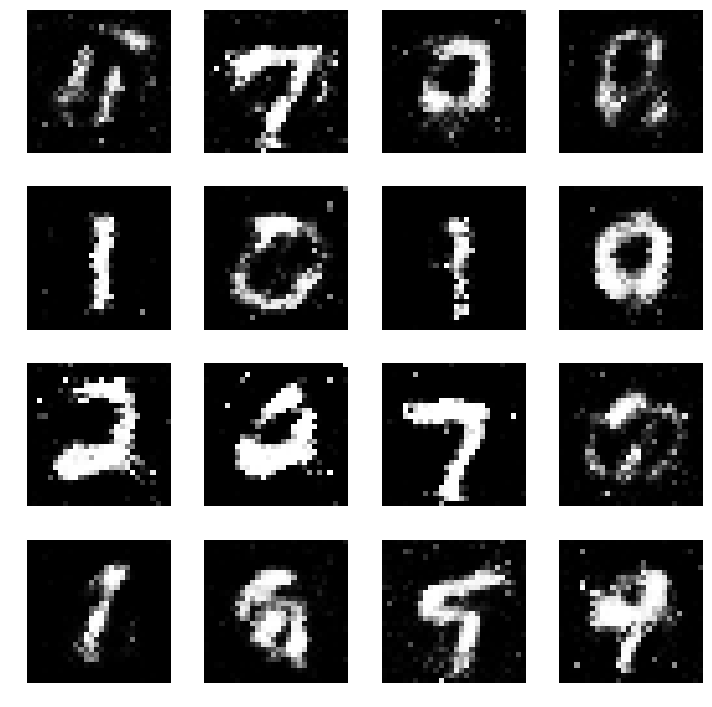

epoch: 20000, [Discriminator :: d_loss: 0.666623], [ Generator :: loss: 0.993510]


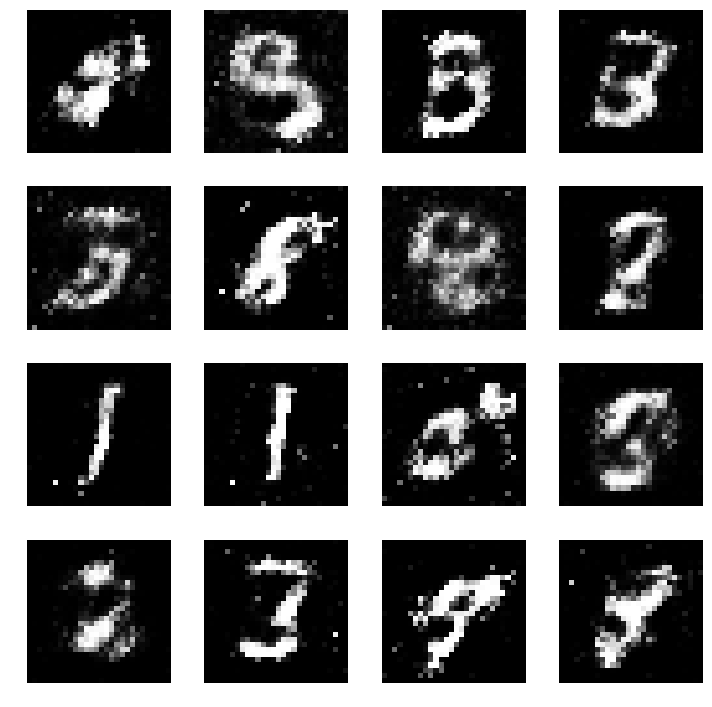

epoch: 21000, [Discriminator :: d_loss: 0.512532], [ Generator :: loss: 0.712985]


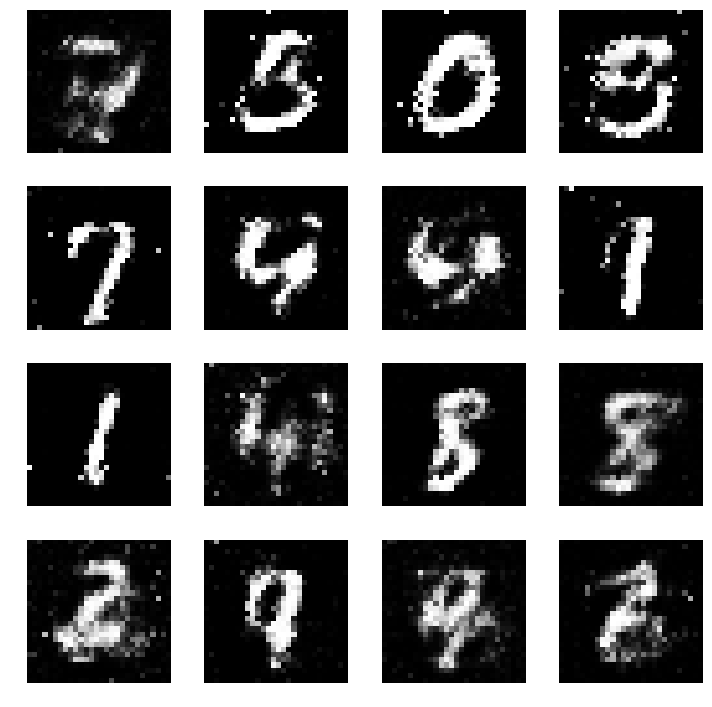

epoch: 22000, [Discriminator :: d_loss: 0.391528], [ Generator :: loss: 1.014546]


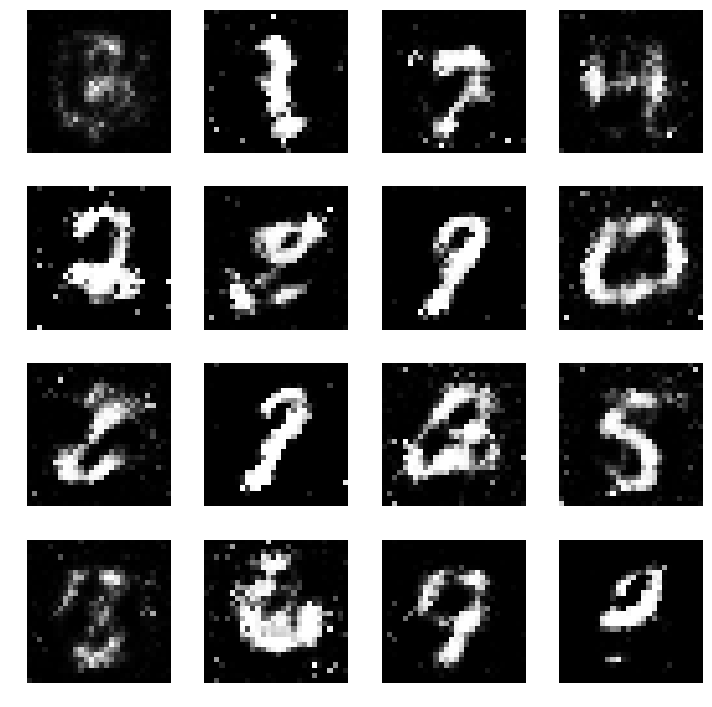

epoch: 23000, [Discriminator :: d_loss: 0.526573], [ Generator :: loss: 0.900059]


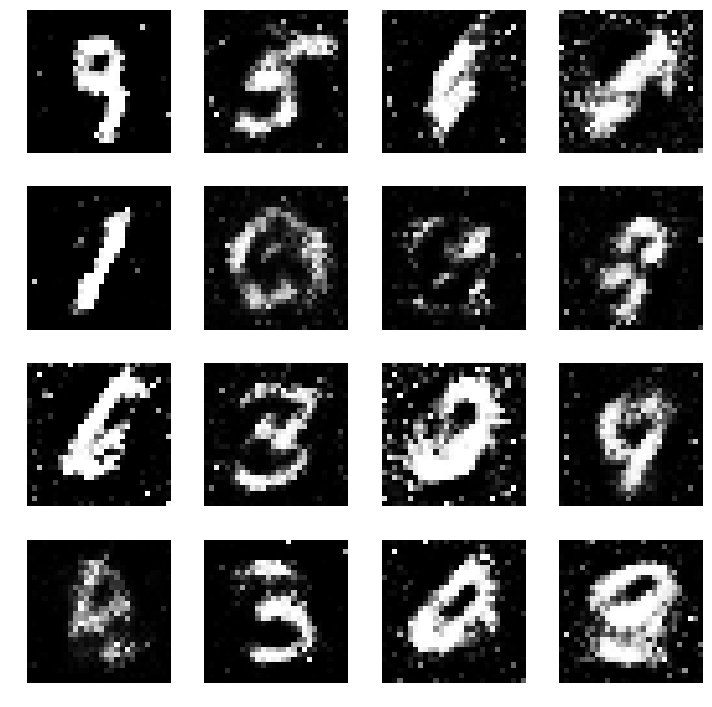

epoch: 24000, [Discriminator :: d_loss: 0.623108], [ Generator :: loss: 1.279521]


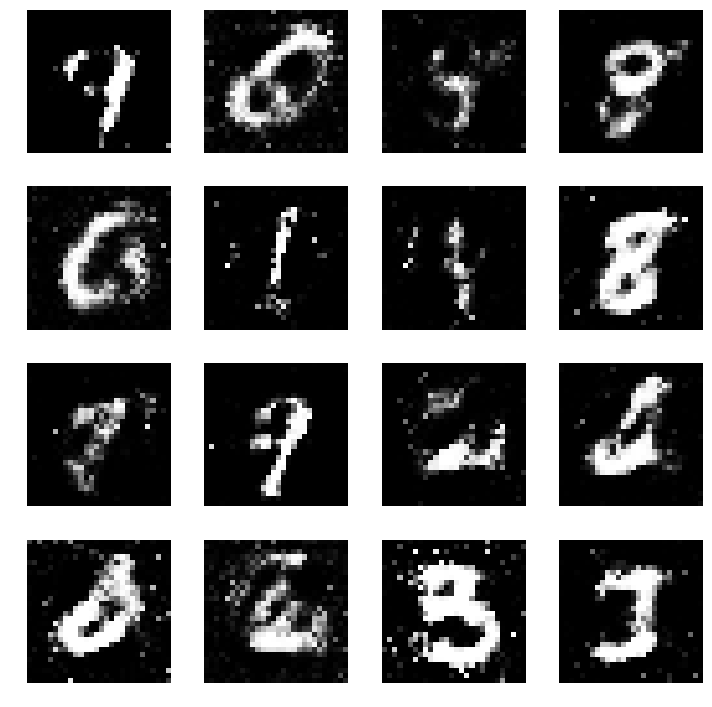

epoch: 25000, [Discriminator :: d_loss: 0.782872], [ Generator :: loss: 0.841712]


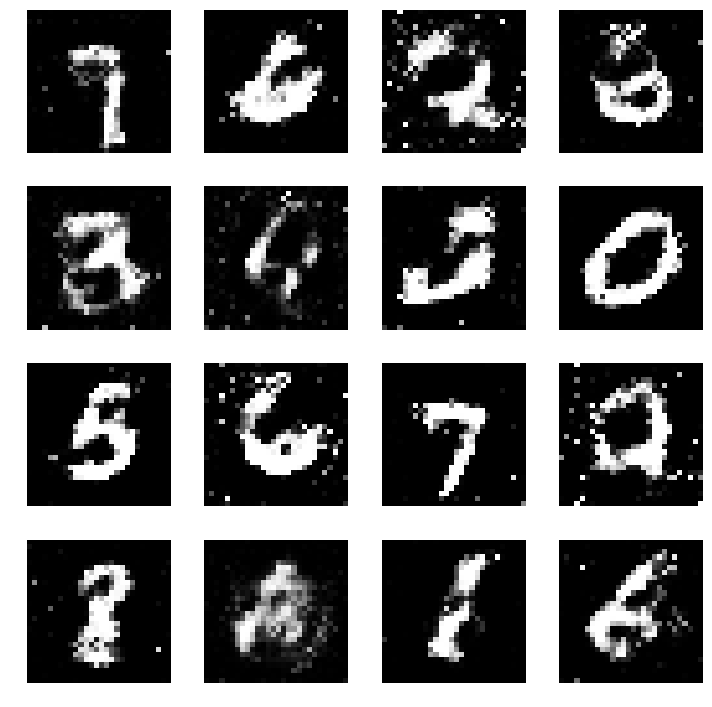

epoch: 26000, [Discriminator :: d_loss: 0.489116], [ Generator :: loss: 1.094141]


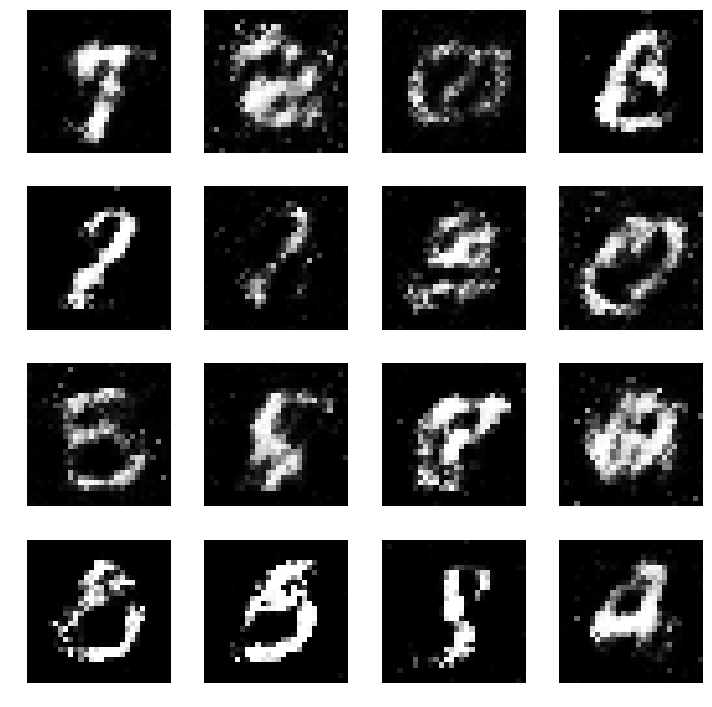

epoch: 27000, [Discriminator :: d_loss: 0.783841], [ Generator :: loss: 1.465143]


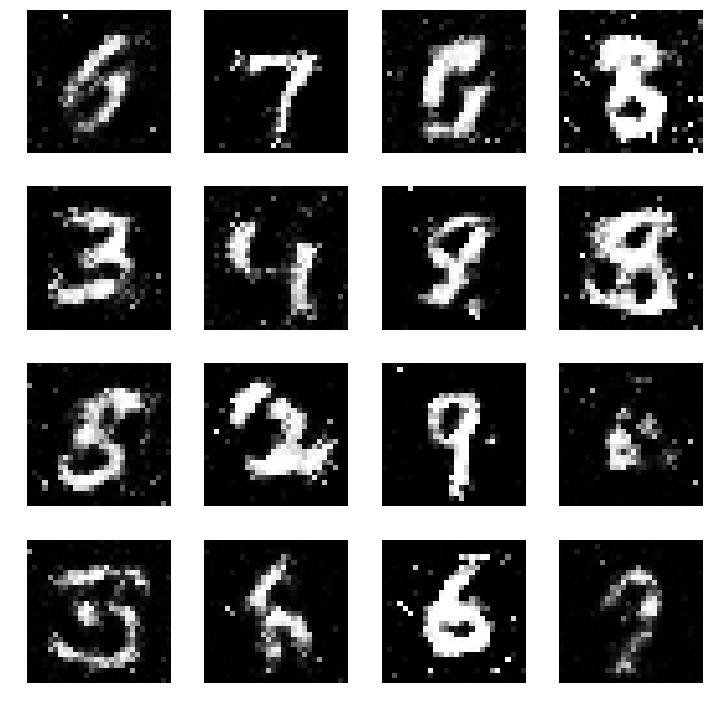

epoch: 28000, [Discriminator :: d_loss: 0.750873], [ Generator :: loss: 1.083563]


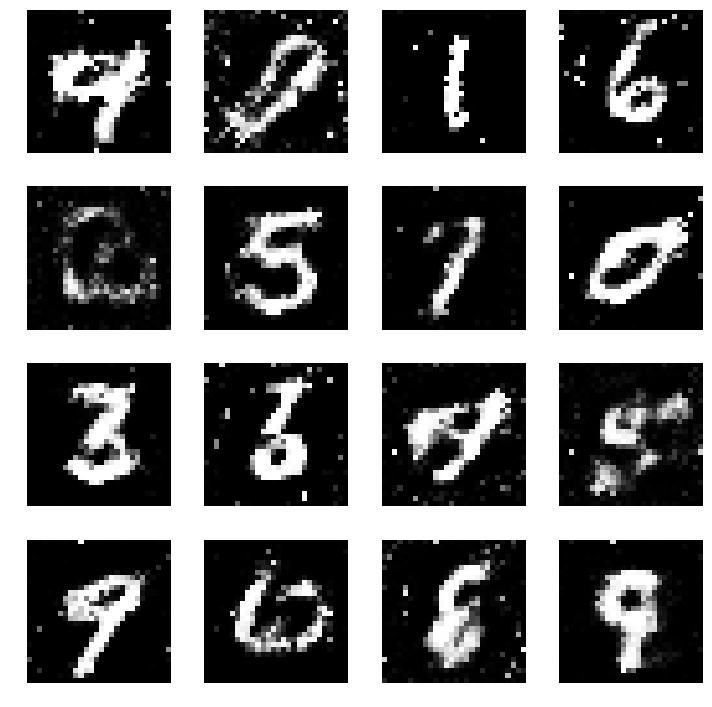

epoch: 29000, [Discriminator :: d_loss: 0.597854], [ Generator :: loss: 1.089100]


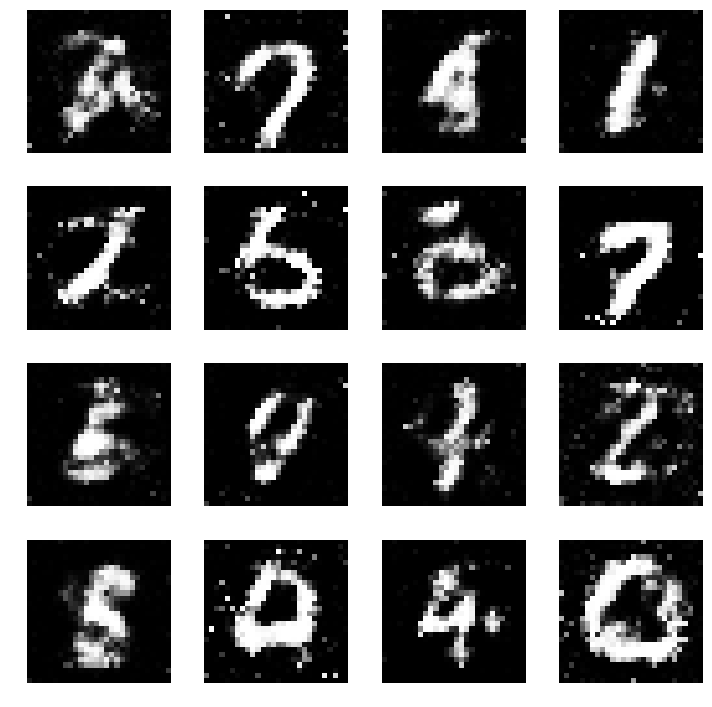

epoch: 30000, [Discriminator :: d_loss: 0.532652], [ Generator :: loss: 1.557641]


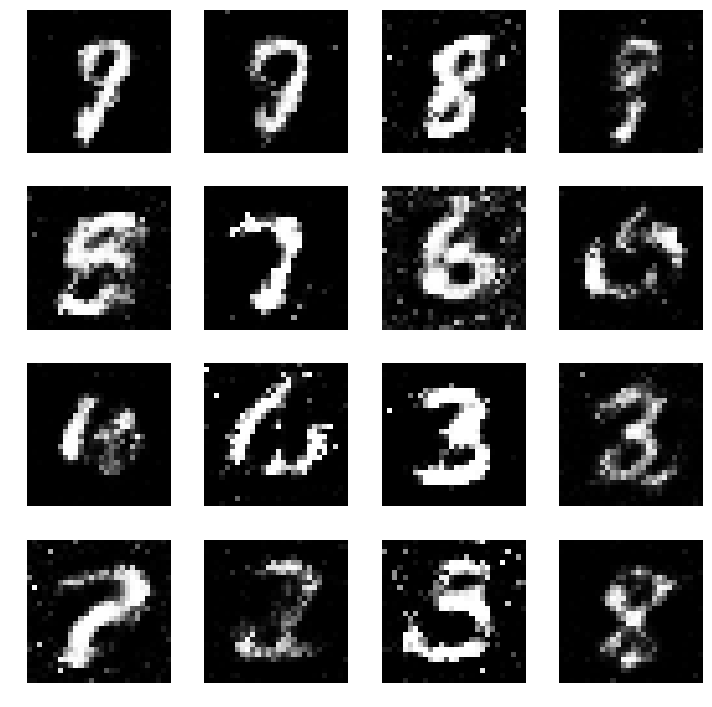

epoch: 31000, [Discriminator :: d_loss: 0.520782], [ Generator :: loss: 0.966678]


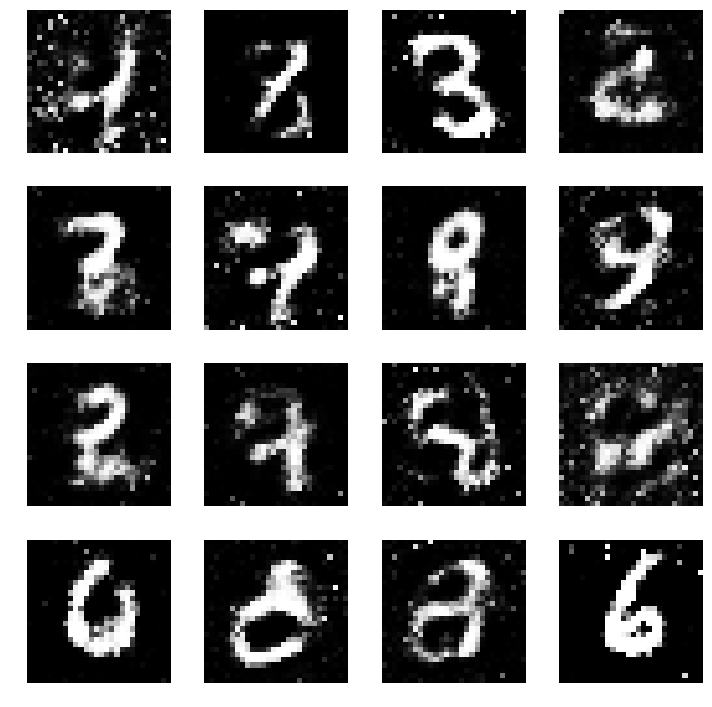

epoch: 32000, [Discriminator :: d_loss: 0.436460], [ Generator :: loss: 1.061179]


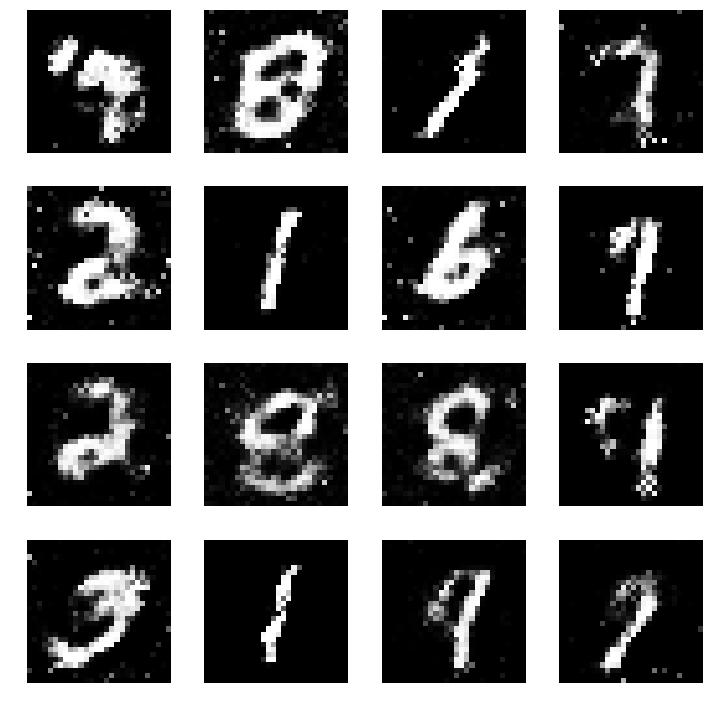

epoch: 33000, [Discriminator :: d_loss: 0.509897], [ Generator :: loss: 1.457820]


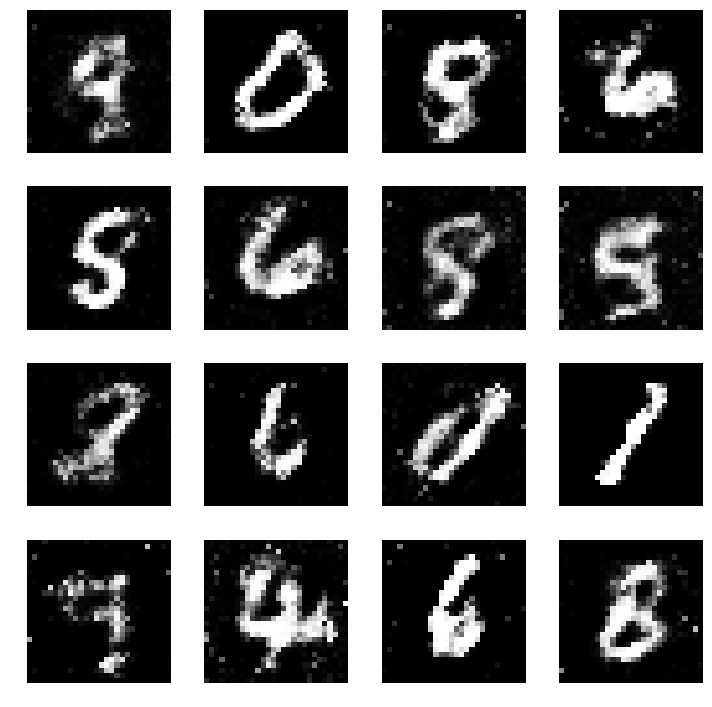

epoch: 34000, [Discriminator :: d_loss: 0.545071], [ Generator :: loss: 1.298191]


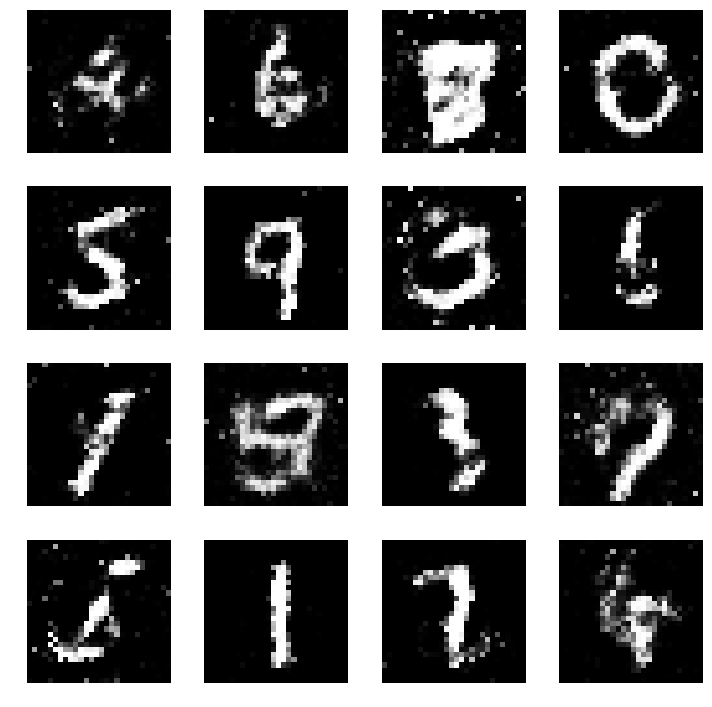

epoch: 35000, [Discriminator :: d_loss: 0.471796], [ Generator :: loss: 0.848108]


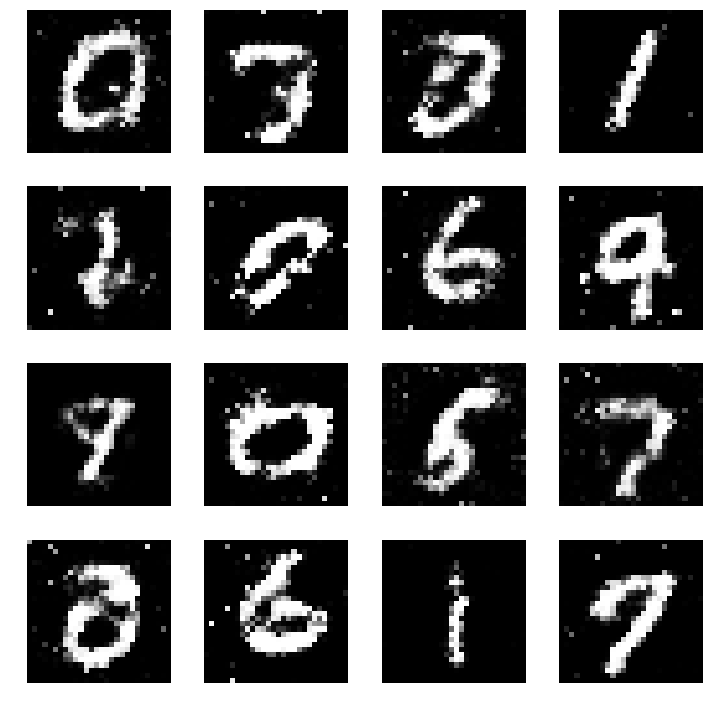

epoch: 36000, [Discriminator :: d_loss: 0.484940], [ Generator :: loss: 0.994431]


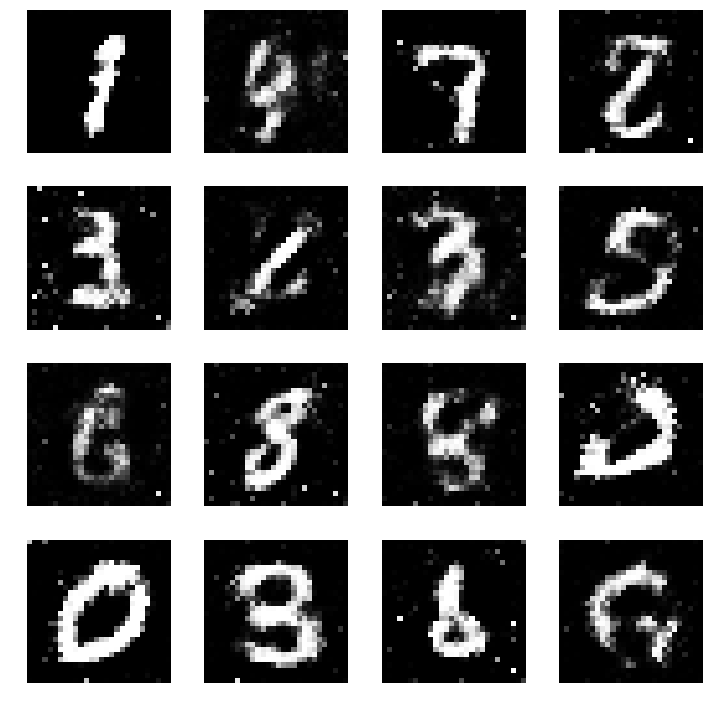

epoch: 37000, [Discriminator :: d_loss: 0.505499], [ Generator :: loss: 1.054080]


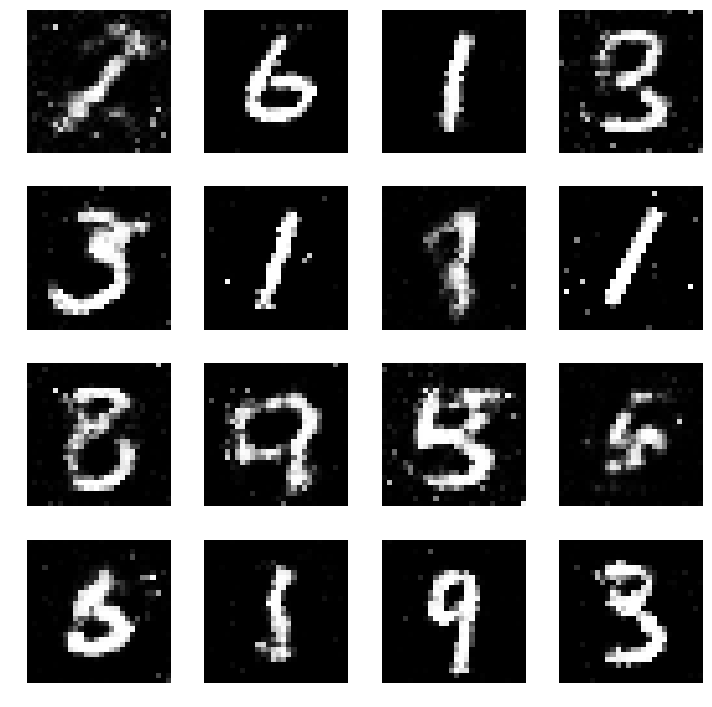

epoch: 38000, [Discriminator :: d_loss: 0.506081], [ Generator :: loss: 1.158654]


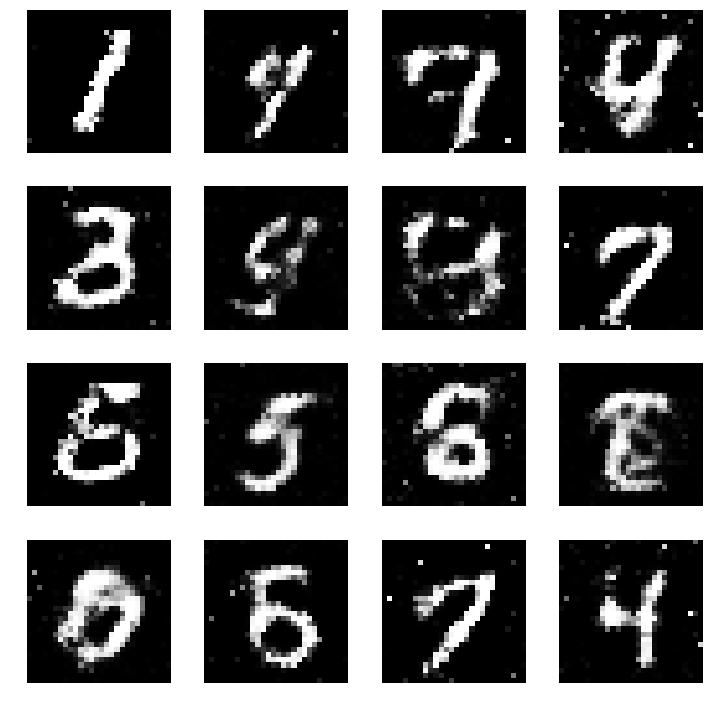

epoch: 39000, [Discriminator :: d_loss: 0.602088], [ Generator :: loss: 1.262932]


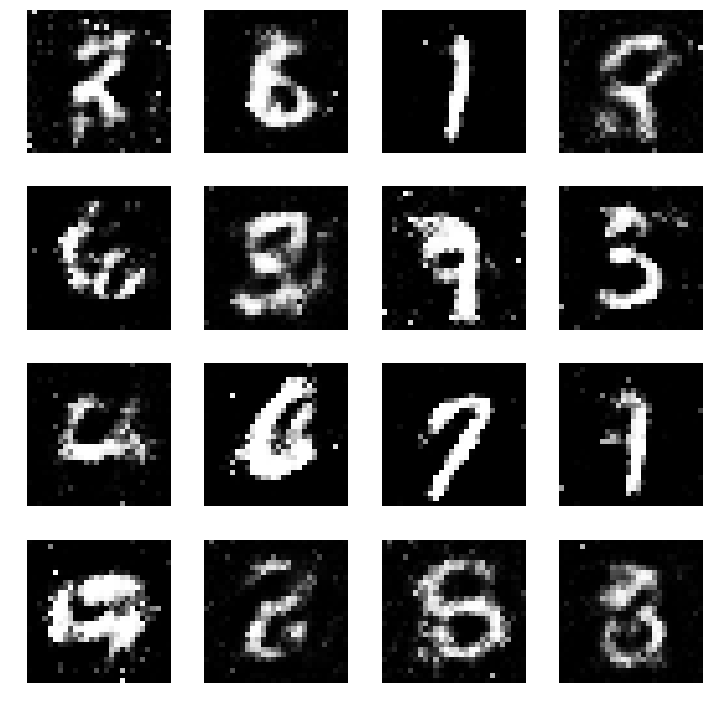

In [4]:
gan.train(X_train, epochs=40000, save_interval = 1000)

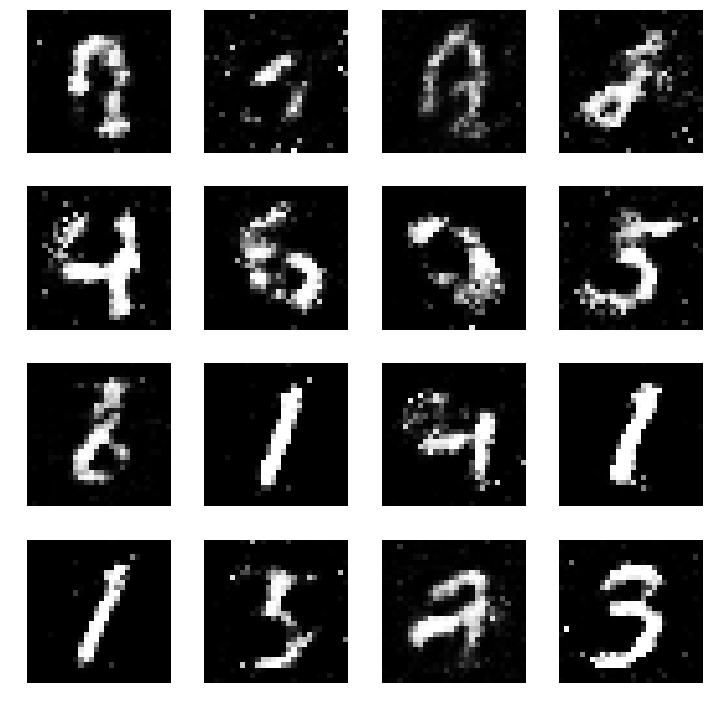

In [5]:
gan.plot_images()